## Imports

In [1]:
print('test')

test


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import simple_norm
import astropy.units as u 
from astropy.coordinates import SkyCoord
import regions
from regions import Regions
from astropy.table import Table
import os

from spectral_cube import SpectralCube
import importlib as imp

from dust_extinction.averages import CT06_MWLoc, I05_MWAvg, CT06_MWGC, G21_MWAvg, RL85_MWGC, RRP89_MWGC, F11_MWGC

In [3]:
cd ..

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [4]:
from jwst_plots import JWSTCatalog, make_cat_use, make_brick_cat
import cutout_manager as cm
import jwst_plots
import co_ice as co_map
imp.reload(co_map)
import extinction as ex

In [5]:
cd notebooks

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


In [6]:
import icemodels
imp.reload(icemodels)
from icemodels.core import optical_constants_cache_dir, read_ocdb_file, download_all_ocdb, composition_to_molweight
from icemodels import absorbed_spectrum, absorbed_spectrum_Gaussians, convsum, fluxes_in_filters, load_molecule, load_molecule_ocdb, atmo_model, molecule_data
from icemodels.gaussian_model_components import co_ice_wls_icm, co_ice_wls, co_ice_widths, co_ice_bandstrength
from astroquery.svo_fps import SvoFps
from astropy import table
co_ice_wls, co_ice_widths


(<Quantity [4.66483183, 4.67311557, 4.68055231] um>,
 <Quantity [0.0065282 , 0.0076433 , 0.02322202] um>)

# Exploring Other Ices

In [14]:
filter_data = SvoFps.get_filter_list('JWST', instrument="NIRCam")
filter_data.add_index('filterID')
flxd = filter_data['filterID']
jfilts = SvoFps.get_filter_list('JWST')
jfilts.add_index('filterID')

## Opacities

In [111]:
lis = co_map.list_consts_files('_CO_', verbose=True)

63_CO_(1)_25K_Gerakines.txt
75_CO_1_762_45.0K.txt
61_CO_1_548_15.0K.txt
75_CO_1_760_35.0K.txt
75_CO_1_761_40.0K.txt
43_CO_(1)_12K_Elsila.txt
61_CO_1_555_35.0K.txt
267_CO_(1)_15K_Palumbo.txt
61_CO_1_553_28.0K.txt
61_CO_1_549_18.0K.txt
75_CO_1_754_15.0K.txt
85_CO_(1)_10K_Hudgins.txt
61_CO_1_552_25.0K.txt
269_CO_(1)_15K_Palumbo.txt
34_CO_(1)_10K_Ehrenfreund.txt
75_CO_1_758_25.0K.txt
75_CO_1_759_30.0K.txt
64_CO_(1)_25K_Gerakines.txt
35_CO_(1)_30K_Ehrenfreund.txt
75_CO_1_756_20.0K.txt
1_CO_(1)_12.5K_Baratta.txt
61_CO_1_554_30.0K.txt
61_CO_1_550_20.0K.txt
75_CO_1_757_22.0K.txt
75_CO_1_755_18.0K.txt
61_CO_1_551_22.5K.txt


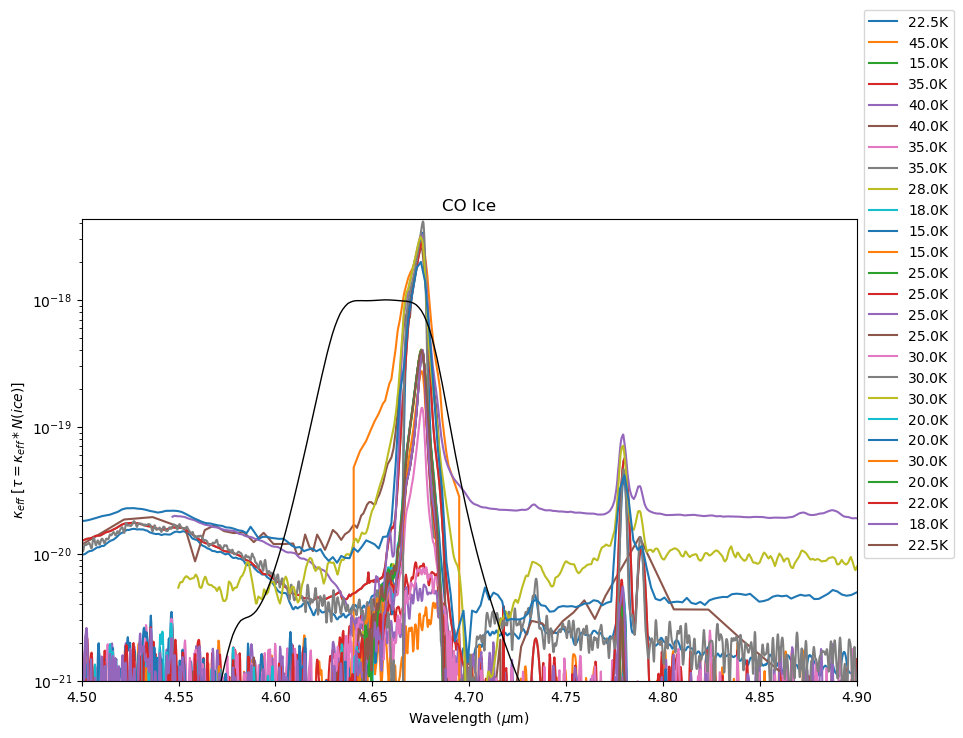

In [ ]:
figure = plt.figure(figsize=(10, 6))
filterid = 'JWST/NIRCam.F466N'
xarr = np.linspace(filter_data.loc[filterid]['WavelengthMin'] * u.AA,
                   filter_data.loc[filterid]['WavelengthMax'] * u.AA,
                   1000)
xarr = np.linspace(3.5*u.um, 4.9*u.um, 5000)
phx4000 = atmo_model(4000, xarr=xarr)
lis = co_map.list_consts_files('_CO_', verbose=False)
i=0
for consts_file in lis:
    try: 
        consts = read_ocdb_file(f'{consts_file}')
    except:
        consts = Table.read(f'{consts_file}', format='ascii')
        consts.rename_column('col1', 'Wavenumber (cm⁻¹)_1')
        consts['Wavelength'] = 1e4 / consts['Wavenumber (cm⁻¹)_1'] * u.um
        consts.rename_column('col2', 'k')
        consts.meta['density'] = 1.0 * u.g / u.cm**3
        label = consts_file.split('/')[-1].split('_')[-1][:-4]
        consts.meta['composition'] = 'CO'
        
    molwt = composition_to_molweight(consts.meta['composition'])
    plt.plot(consts['Wavelength'], (consts['k'] * consts['Wavelength'].to(u.cm**-1, u.spectral()) * 4 * np.pi / (1*u.g/u.cm**3 / (molwt))).to(u.cm**2), label=label)
    i+=1
plt.xlim(4.5, 4.9)
plt.ylim(bottom=1e-21)

trans = SvoFps.get_transmission_data(filterid)
plt.plot(trans['Wavelength'].quantity.to(u.um),
        trans['Transmission'].value/trans['Transmission'].value.max()*1e-18,
        linewidth=1,
        color='k')

plt.xlabel("Wavelength ($\\mu$m)")
plt.ylabel("$\\kappa_{eff}$ [$\\tau = \\kappa_{eff} * N(ice)$]")
plt.legend(loc='best', bbox_to_anchor=(1, 0.25))
plt.title('CO Ice')
plt.yscale('log')

Text(0.5, 1.0, 'CO')

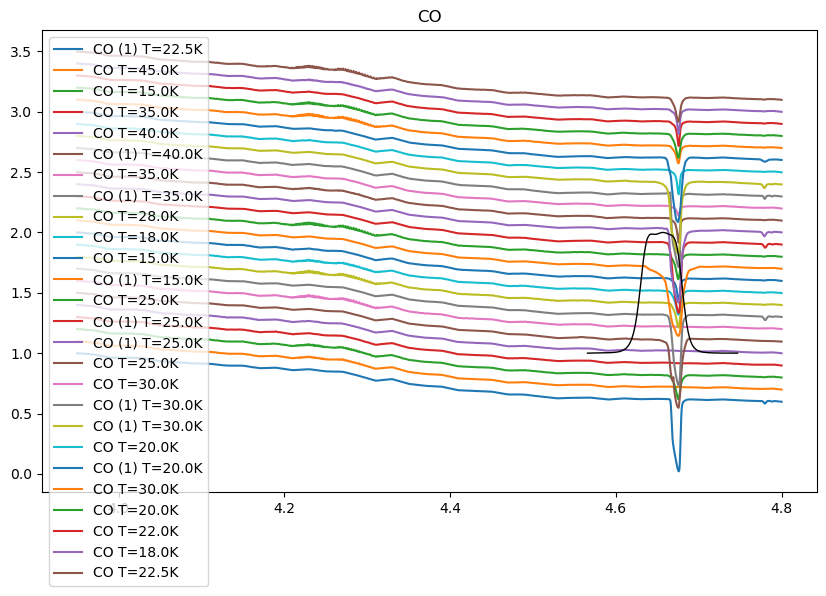

In [ ]:
N_CO = 1e18 * u.cm**-2

#consts_file = lis[0].split('/')[-1] #'22_HCN (1)_95K_Dello.txt'
figure = plt.figure(figsize=(10, 6))
filterid = 'JWST/NIRCam.F466N'
xarr = np.linspace(filter_data.loc[filterid]['WavelengthMin'] * u.AA,
                   filter_data.loc[filterid]['WavelengthMax'] * u.AA,
                   1000)
xarr = np.linspace(3.95*u.um, 4.8*u.um, 5000)
lis = co_map.list_consts_files('_CO_', verbose=False)
phx4000 = atmo_model(4000, xarr=xarr)
i=0
for consts_file in lis:
    try: 
        consts = read_ocdb_file(f'{consts_file}')
    except:
        consts = Table.read(f'{consts_file}', format='ascii')
        consts.rename_column('col1', 'Wavenumber (cm⁻¹)_1')
        consts['Wavelength'] = 1e4 / consts['Wavenumber (cm⁻¹)_1'] * u.um
        consts.rename_column('col2', 'k')
        consts.meta['density'] = 1.0 * u.g / u.cm**3
        label = consts_file.split('/')[-1].split('_')[-1][:-4]
        consts.meta['composition'] = 'CO'
        
    molwt = composition_to_molweight('CO')

    aspec = absorbed_spectrum(N_CO, consts, spectrum=phx4000['fnu'], xarr=xarr, molecular_weight=molwt)
    plt.plot(xarr.to(u.um), aspec / aspec.max()+i, label=f'{consts.meta['composition']} T={label}')
    i += 0.1
plt.legend()

trans = SvoFps.get_transmission_data(filterid)
plt.plot(trans['Wavelength'].quantity.to(u.um),
        trans['Transmission'].value/trans['Transmission'].value.max() + 1,
        linewidth=1,
        color='k')
plt.title('CO')

Text(0.5, 1.0, '63_CO_(1)_25K_Gerakines.txt')

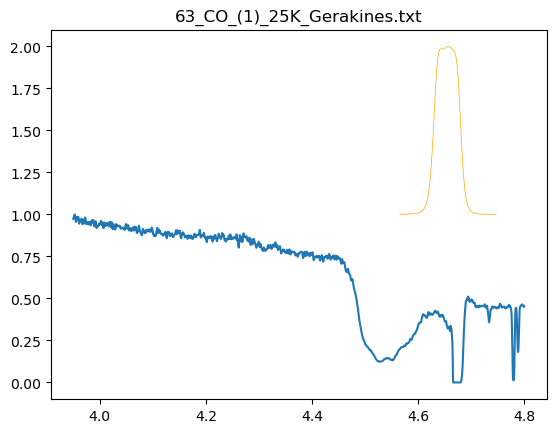

In [ ]:
lis = co_map.list_consts_files('_CO_', verbose=False)
consts_file = lis[0].split('/')[-1] #'22_HCN (1)_95K_Dello.txt'

filterid = 'JWST/NIRCam.F466N'
xarr = np.linspace(filter_data.loc[filterid]['WavelengthMin'] * u.AA,
                   filter_data.loc[filterid]['WavelengthMax'] * u.AA,
                   1000)
xarr = np.linspace(3.95*u.um, 4.8*u.um, 5000)
phx4000 = atmo_model(4000, xarr=xarr)
consts = read_ocdb_file(f'{optical_constants_cache_dir}/{consts_file}')
molwt = composition_to_molweight(consts.meta['composition'])

aspec = absorbed_spectrum(1e20*u.cm**-2, consts, spectrum=phx4000['fnu'], xarr=xarr, molecular_weight=molwt)
plt.plot(xarr.to(u.um), aspec / aspec.max())

trans = SvoFps.get_transmission_data(filterid)
plt.plot(trans['Wavelength'].quantity.to(u.um),
        trans['Transmission'].value/trans['Transmission'].value.max() + 1,
        linewidth=0.5,
        color='orange')
plt.title(consts_file)

158_OCN-_1_1172_12.0K.txt
158_OCN-_1_1143_80.0K.txt


158_OCN-_1_1172_12.0K.txt
158_OCN-_1_1143_80.0K.txt


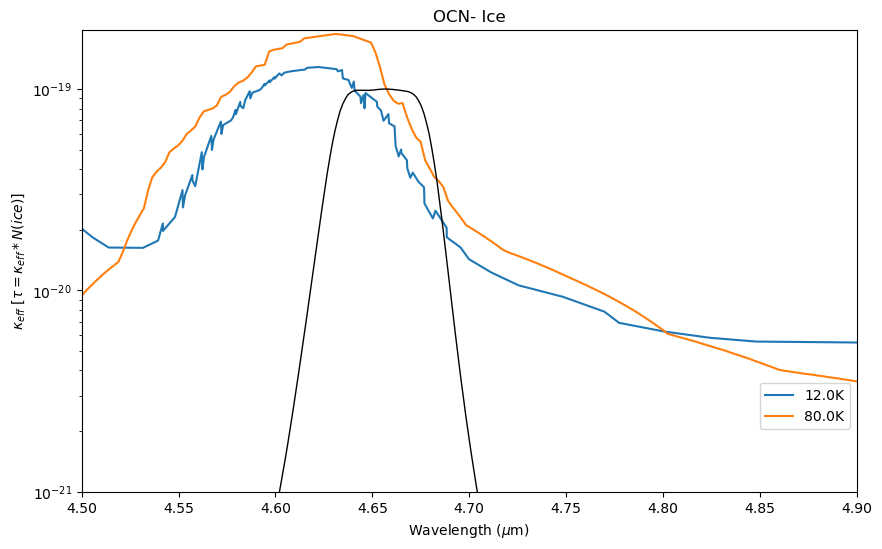

In [ ]:
figure = plt.figure(figsize=(10, 6))
filterid = 'JWST/NIRCam.F466N'
xarr = np.linspace(filter_data.loc[filterid]['WavelengthMin'] * u.AA,
                   filter_data.loc[filterid]['WavelengthMax'] * u.AA,
                   1000)
xarr = np.linspace(3.5*u.um, 4.9*u.um, 5000)
phx4000 = atmo_model(4000, xarr=xarr)
i=0
lis = co_map.list_consts_files('OCN', verbose=True)
for consts_file in lis:
    try: 
        consts = read_ocdb_file(f'{consts_file}')
    except:
        consts = Table.read(f'{consts_file}', format='ascii')
        consts.rename_column('col1', 'Wavenumber (cm⁻¹)_1')
        consts['Wavelength'] = 1e4 / consts['Wavenumber (cm⁻¹)_1'] * u.um
        consts.rename_column('col2', 'k')
        consts.meta['density'] = 1.0 * u.g / u.cm**3
        label = consts_file.split('/')[-1].split('_')[-1][:-4]
        consts.meta['composition'] = 'OCN'
        
    molwt = composition_to_molweight(consts.meta['composition'])
    plt.plot(consts['Wavelength'], (consts['k'] * consts['Wavelength'].to(u.cm**-1, u.spectral()) * 4 * np.pi / (1*u.g/u.cm**3 / (molwt))).to(u.cm**2), label=label)
    i+=1
plt.xlim(4.5, 4.9)
plt.ylim(bottom=1e-21)
plt.xlabel("Wavelength ($\\mu$m)")
plt.ylabel("$\\kappa_{eff}$ [$\\tau = \\kappa_{eff} * N(ice)$]")
plt.legend(loc='best', bbox_to_anchor=(1, 0.25))
plt.title('OCN- Ice')
plt.yscale('log')

trans = SvoFps.get_transmission_data(filterid)
plt.plot(trans['Wavelength'].quantity.to(u.um),
        trans['Transmission'].value/trans['Transmission'].value.max()*1e-19,
        linewidth=1,
        color='k')

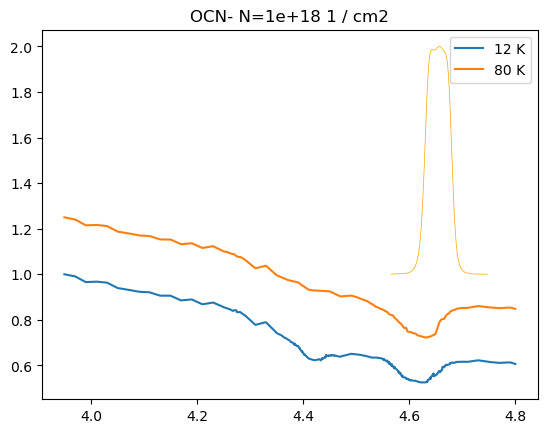

In [ ]:
N_OCN = 1e18*u.cm**-2

consts_file = '158_OCN-_1_1172_12.0K.txt' #lis[0].split('/')[-1] #'22_HCN (1)_95K_Dello.txt'

filterid = 'JWST/NIRCam.F466N'
xarr = np.linspace(filter_data.loc[filterid]['WavelengthMin'] * u.AA,
                   filter_data.loc[filterid]['WavelengthMax'] * u.AA,
                   1000)
xarr = np.linspace(3.95*u.um, 4.8*u.um, 5000)
phx4000 = atmo_model(4000, xarr=xarr)
#consts = read_ocdb_file(f'{optical_constants_cache_dir}/{consts_file}')
consts = Table.read(f'{optical_constants_cache_dir}/{consts_file}', format='ascii')
consts.rename_column('col1', 'Wavenumber (cm⁻¹)_1')
consts['Wavelength'] = 1e4 / consts['Wavenumber (cm⁻¹)_1'] * u.um
consts.rename_column('col2', 'k')
consts.meta['density'] = 1.0 * u.g / u.cm**3
molwt = composition_to_molweight('OCN')

aspec = absorbed_spectrum(N_OCN, consts, spectrum=phx4000['fnu'], xarr=xarr, molecular_weight=molwt)
plt.plot(xarr.to(u.um), aspec / aspec.max(), label='12 K')

consts_file = '158_OCN-_1_1143_80.0K.txt'
consts = Table.read(f'{optical_constants_cache_dir}/{consts_file}', format='ascii')
consts.rename_column('col1', 'Wavenumber (cm⁻¹)_1')
consts['Wavelength'] = 1e4 / consts['Wavenumber (cm⁻¹)_1'] * u.um
consts.rename_column('col2', 'k')
consts.meta['density'] = 1.0 * u.g / u.cm**3
molwt = composition_to_molweight('OCN')

aspec = absorbed_spectrum(N_OCN, consts, spectrum=phx4000['fnu'], xarr=xarr, molecular_weight=molwt)
plt.plot(xarr.to(u.um), aspec / aspec.max() + 0.25, label='80 K')

trans = SvoFps.get_transmission_data(filterid)
plt.plot(trans['Wavelength'].quantity.to(u.um),
        trans['Transmission'].value/trans['Transmission'].value.max() + 1,
        linewidth=0.5,
        color='orange')

#filterid = 'JWST/NIRCam.F410M'
#trans = SvoFps.get_transmission_data(filterid)
#plt.plot(trans['Wavelength'].quantity.to(u.um),
#        trans['Transmission'].value/trans['Transmission'].value.max() + 1,
#        linewidth=0.5,
#        color='orange')
#
#filterid = 'JWST/NIRCam.F405N'
#trans = SvoFps.get_transmission_data(filterid)
#plt.plot(trans['Wavelength'].quantity.to(u.um),
#        trans['Transmission'].value/trans['Transmission'].value.max() + 1,
#        linewidth=0.5,
#        color='orange')
plt.title(f'OCN- N={N_OCN}')
plt.legend()

In [146]:
co_map.list_consts_files('_OCS_', verbose=True)

160_OCS_1_1145_17.0K.txt
154_OCS_(1)_60K_Hudgins.txt
153_OCS_(1)_50K_Hudgins.txt
152_OCS_(1)_10K_Hudgins.txt


['/red/adamginsburg/repos/icemodels/icemodels/data/160_OCS_1_1145_17.0K.txt',
 '/red/adamginsburg/repos/icemodels/icemodels/data/154_OCS_(1)_60K_Hudgins.txt',
 '/red/adamginsburg/repos/icemodels/icemodels/data/153_OCS_(1)_50K_Hudgins.txt',
 '/red/adamginsburg/repos/icemodels/icemodels/data/152_OCS_(1)_10K_Hudgins.txt']

Text(0.5, 1.0, 'OCS Ice')

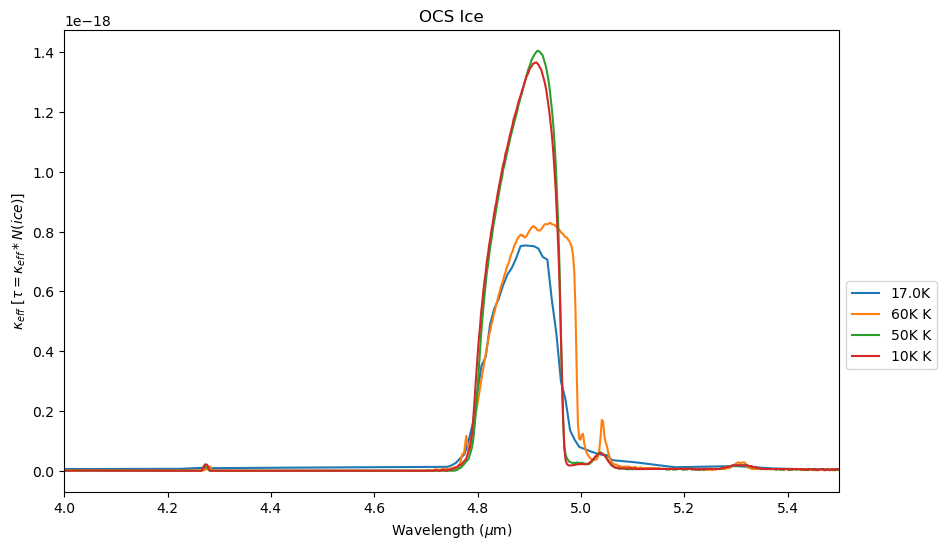

In [ ]:
figure = plt.figure(figsize=(10, 6))
filterid = 'JWST/NIRCam.F466N'
xarr = np.linspace(filter_data.loc[filterid]['WavelengthMin'] * u.AA,
                   filter_data.loc[filterid]['WavelengthMax'] * u.AA,
                   1000)
xarr = np.linspace(3.95*u.um, 5.4*u.um, 5000)
phx4000 = atmo_model(4000, xarr=xarr)
i=0
lis = co_map.list_consts_files('_OCS_', verbose=False)
for consts_file in lis:
    try: 
        consts = read_ocdb_file(f'{consts_file}')
        label = f'{consts.meta['temperature']}' + ' K'
    except:
        consts = Table.read(f'{consts_file}', format='ascii')
        consts.rename_column('col1', 'Wavenumber (cm⁻¹)_1')
        consts['Wavelength'] = 1e4 / consts['Wavenumber (cm⁻¹)_1'] * u.um
        consts.rename_column('col2', 'k')
        consts.meta['density'] = 1.0 * u.g / u.cm**3
        label = consts_file.split('/')[-1].split('_')[-1][:-4]
        consts.meta['composition'] = 'OCS'
    molwt = composition_to_molweight(consts.meta['composition'])
    plt.plot(consts['Wavelength'], (consts['k'] * consts['Wavelength'].to(u.cm**-1, u.spectral()) * 4 * np.pi / (1*u.g/u.cm**3 / (molwt))).to(u.cm**2), label=label)
    i+=1
plt.xlim(4, 5.5)
plt.xlabel("Wavelength ($\\mu$m)")
plt.ylabel("$\\kappa_{eff}$ [$\\tau = \\kappa_{eff} * N(ice)$]")
plt.legend(loc='best', bbox_to_anchor=(1, 0.25))
plt.title('OCS Ice')

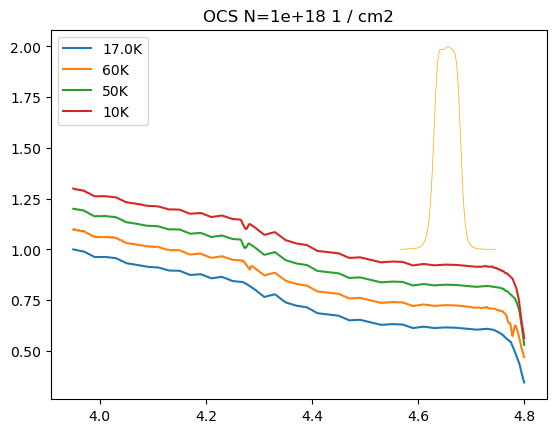

In [ ]:
lis = co_map.list_consts_files('_OCS_', verbose=False)

N_OCS = 1e18*u.cm**-2

xarr = np.linspace(filter_data.loc[filterid]['WavelengthMin'] * u.AA,
                   filter_data.loc[filterid]['WavelengthMax'] * u.AA,
                   1000)
xarr = np.linspace(3.95*u.um, 4.8*u.um, 5000)
phx4000 = atmo_model(4000, xarr=xarr)
i = 0.0

for consts_file in lis: 
    try: 
        consts = read_ocdb_file(f'{consts_file}')
        label = consts_file.split('/')[-1].split('_')[-2]
    except:
        consts = Table.read(f'{consts_file}', format='ascii')
        consts.rename_column('col1', 'Wavenumber (cm⁻¹)_1')
        consts['Wavelength'] = 1e4 / consts['Wavenumber (cm⁻¹)_1'] * u.um
        consts.rename_column('col2', 'k')
        consts.meta['density'] = 1.0 * u.g / u.cm**3
        label = consts_file.split('/')[-1].split('_')[-1][:-4]
    molwt = composition_to_molweight('OCS')

    aspec = absorbed_spectrum(N_OCS, consts, spectrum=phx4000['fnu'], xarr=xarr, molecular_weight=molwt)
    
    plt.plot(xarr.to(u.um), aspec / aspec.max()+i, label=label)
    i += 0.1

filterid = 'JWST/NIRCam.F466N'
trans = SvoFps.get_transmission_data(filterid)
plt.plot(trans['Wavelength'].quantity.to(u.um),
        trans['Transmission'].value/trans['Transmission'].value.max() + 1,
        linewidth=0.5,
        color='orange')
plt.title(f'OCS N={N_OCS}')
plt.legend()

## Column Densities

In [ ]:
consts_file = '158_OCN-_1_1172_12.0K.txt' #lis[0].split('/')[-1] #'22_HCN (1)_95K_Dello.txt'

filterid = 'JWST/NIRCam.F466N'
xarr = np.linspace(filter_data.loc[filterid]['WavelengthMin'] * u.AA,
                   filter_data.loc[filterid]['WavelengthMax'] * u.AA,
                   1000)
phx4000 = atmo_model(4000, xarr=xarr)
#consts = read_ocdb_file(f'{optical_constants_cache_dir}/{consts_file}')
consts = Table.read(f'{optical_constants_cache_dir}/{consts_file}', format='ascii')
consts.rename_column('col1', 'Wavenumber (cm⁻¹)_1')
consts['Wavelength'] = 1e4 / consts['Wavenumber (cm⁻¹)_1'] * u.um
consts.rename_column('col2', 'k')
consts.meta['density'] = 1.0 * u.g / u.cm**3
molwt = composition_to_molweight('OCN')
#1_CO_(1)_12.5K_Baratta.txt')#
#consts = load_molecule_ocdb(molecule) # OCDB = optical constants database
# phx4000 = stellar atmosphere model spectrum at 4000K
xarr = phx4000['nu'].quantity.to(u.um, u.spectral())
# column densities of CO ice
cols = np.geomspace(1e15, 1e20, 25)
dmags410 = []
dmags466 = []

print(f"  column,   mag410,  mag410*,  mag466n, mag466n*, dmag410, dmag466")
for col in cols:
    # for each column density of CO (ice?), make a spectrum of it 
    # absorbed_spectrum takes spectrum and puts the effects of an absorption feature in front of it 
    spec = absorbed_spectrum(col*u.cm**-2, consts, molecular_weight=molwt,
                              spectrum=phx4000['fnu'].quantity, # flux array
                              xarr=xarr, # wavelength array
                             )
    cmd_x = ('JWST/NIRCam.F410M', 'JWST/NIRCam.F466N')
    flxd_ref = fluxes_in_filters(xarr, phx4000['fnu'].quantity)
    flxd = fluxes_in_filters(xarr, spec)
    # the star's magnitude
    mags_x_star = (-2.5*np.log10(flxd_ref[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                   -2.5*np.log10(flxd_ref[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
    # the magnitude of the star with the CO ice
    #mags_x = flxd[cmd_x[0]].to(u.ABmag).value, flxd[cmd_x[1]].to(u.ABmag).value
    mags_x = (-2.5*np.log10(flxd[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
              -2.5*np.log10(flxd[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
    # the difference in magnitudes in F410M and F466N
    dmags466.append(mags_x[1]-mags_x_star[1])
    dmags410.append(mags_x[0]-mags_x_star[0])
    # why would f410m change at all?
    print(f"{col:8.1g}, {mags_x[0]:8.1f}, {mags_x_star[0]:8.1f}, {mags_x[1]:8.1f}, {mags_x_star[1]:8.1f}, {dmags410[-1]:8.1f}, {dmags466[-1]:8.1f}")

  column,   mag410,  mag410*,  mag466n, mag466n*, dmag410, dmag466
   1e+15,    -13.7,    -13.7,    -14.0,    -14.0,      0.0,      0.0
   2e+15,    -13.7,    -13.7,    -14.0,    -14.0,      0.0,      0.0
   3e+15,    -13.7,    -13.7,    -14.0,    -14.0,      0.0,      0.0
   4e+15,    -13.7,    -13.7,    -14.0,    -14.0,      0.0,      0.0
   7e+15,    -13.7,    -13.7,    -14.0,    -14.0,      0.0,      0.0
   1e+16,    -13.7,    -13.7,    -14.0,    -14.0,      0.0,      0.0
   2e+16,    -13.7,    -13.7,    -14.0,    -14.0,      0.0,      0.0
   3e+16,    -13.7,    -13.7,    -14.0,    -14.0,      0.0,      0.0
   5e+16,    -13.7,    -13.7,    -14.0,    -14.0,      0.0,      0.0
   7e+16,    -13.7,    -13.7,    -14.0,    -14.0,      0.0,      0.0
   1e+17,    -13.7,    -13.7,    -14.0,    -14.0,      0.0,      0.0
   2e+17,    -13.7,    -13.7,    -14.0,    -14.0,      0.0,      0.0
   3e+17,    -13.6,    -13.7,    -14.0,    -14.0,      0.1,      0.0
   5e+17,    -13.6,    -13.7,    -13

In [55]:
spec

<Quantity [1.08046602e-23, 1.11745510e-23, 1.15570876e-23, 1.19527015e-23,
           1.23618392e-23, 1.27849625e-23, 1.32225486e-23, 1.36750914e-23,
           1.41431013e-23, 1.46271062e-23, 1.51089758e-23, 1.45398773e-23,
           1.39922385e-23, 1.34652492e-23, 1.29581299e-23, 1.24701306e-23,
           1.20005296e-23, 1.15486325e-23, 1.11137712e-23, 1.06953027e-23,
           1.02926083e-23, 9.90509283e-24, 9.53218348e-24, 9.17332910e-24,
           8.82799939e-24, 8.64956594e-24, 8.57604634e-24, 8.50315484e-24,
           8.43088604e-24, 8.35923459e-24, 8.28819519e-24, 8.21776259e-24,
           8.14793158e-24, 8.07869699e-24, 8.01005371e-24, 7.94199665e-24,
           7.87452080e-24, 7.80762115e-24, 7.74129276e-24, 7.67553073e-24,
           7.61033020e-24, 7.54568635e-24, 7.48159441e-24, 7.41804963e-24,
           7.35504733e-24, 7.29258285e-24, 7.23065157e-24, 7.16924892e-24,
           7.10837036e-24, 7.04801140e-24, 6.98816759e-24, 6.92883449e-24,
           6.87000774e-24

Text(0.5, 1.0, '158_OCN-_1_1172_12.0K.txt')

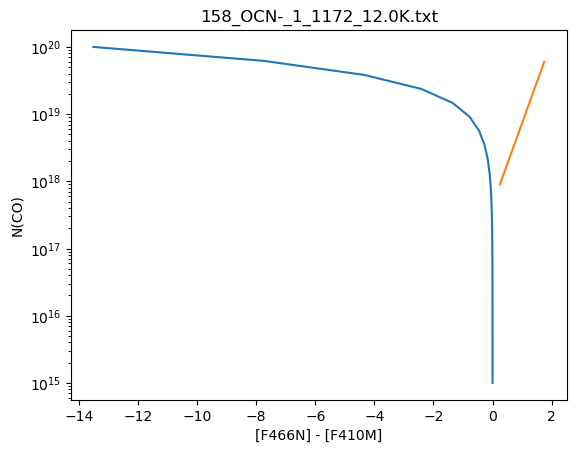

In [12]:
dmag_466m410 = np.array(dmags466) - np.array(dmags410) 
plt.semilogy(dmag_466m410[cols<1e21], cols[cols<1e21])
plt.xlabel('[F466N] - [F410M]')
plt.ylabel('N(CO)')
plt.plot([0.25, 1.75], [9e17, 6e19]);
plt.title(os.path.basename(os.path.normpath(consts_file)))

Text(0.5, 1.0, '158_OCN-_1_1172_12.0K.txt')

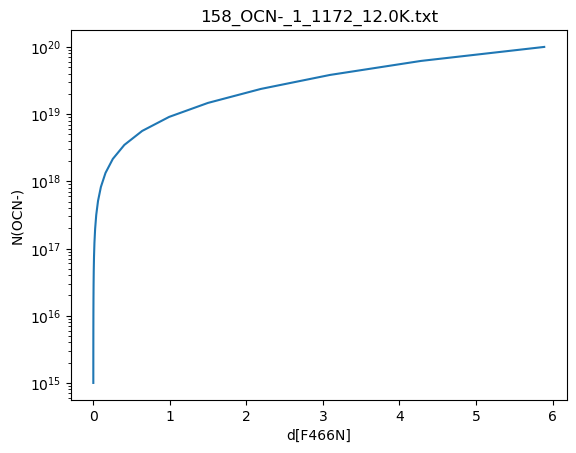

In [72]:
plt.semilogy(np.array(dmags466)[cols<1e21], cols[cols<1e21])
plt.xlabel('d[F466N]')
plt.ylabel('N(OCN-)')
#plt.plot([0.25, 1.75], [9e17, 6e19]);
plt.title(os.path.basename(os.path.normpath(consts_file)))

In [13]:
composition_to_molweight('SiO')*u.Da

<Quantity 44.084905 u>

# Real Spectrum

In [16]:
tbl = Table.read('/orange/adamginsburg/jwst/cloudc/spectra/J110621_JWST_NIRSpec_FS_spectrum_McClure23.txt', comment=';;;', format='ascii', names=['Wavelength (micron)', 'Flux (mJy)', 'u_Flux (mJy)'])

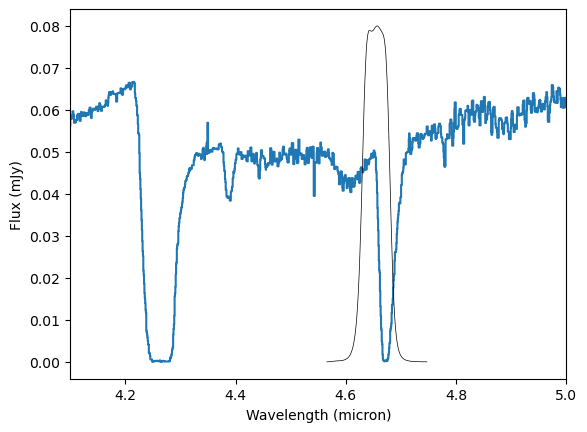

In [17]:
plt.step(tbl['Wavelength (micron)'], tbl['Flux (mJy)'], where='mid')
plt.xlabel('Wavelength (micron)')
plt.ylabel('Flux (mJy)')
plt.xlim(4.1, 5.0)

filterid = 'JWST/NIRCam.F466N'
trans = SvoFps.get_transmission_data(filterid)
plt.plot(trans['Wavelength'].quantity.to(u.um),
        trans['Transmission'].value/trans['Transmission'].value.max()*0.08,
        linewidth=0.5,
        color='k')

In [18]:
tbl['Flux (erg Hz-1 s-1 cm-2)'] = (tbl['Flux (mJy)']*u.mJy).to(u.erg/u.Hz/u.s/u.cm**2, u.spectral_density(tbl['Wavelength (micron)']*u.um))

In [19]:
spec = tbl['Flux (erg Hz-1 s-1 cm-2)']
xarr = tbl['Wavelength (micron)']*u.um
phx4000 = atmo_model(4000, xarr=xarr)
cmd_x = ('JWST/NIRCam.F410M', 'JWST/NIRCam.F466N')
flxd_ref = fluxes_in_filters(xarr, phx4000['fnu'].quantity)
flxd = fluxes_in_filters(xarr, spec.quantity)
# the star's magnitude
mags_x_star = (-2.5*np.log10(flxd_ref[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
               -2.5*np.log10(flxd_ref[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
# the magnitude of the star with the CO ice
#mags_x = flxd[cmd_x[0]].to(u.ABmag).value, flxd[cmd_x[1]].to(u.ABmag).value
mags_x = (-2.5*np.log10(flxd[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
          -2.5*np.log10(flxd[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))

print('F466N:', mags_x[1]-mags_x_star[1])
print('F410M:', mags_x[0]-mags_x_star[0])
print('F410M - F466N = ', mags_x[0]-mags_x[1])

F466N: 30.779125251832653
F410M: 30.672642702182763
F410M - F466N =  -0.23035733844055173


In [20]:
spec_J11 = (0.05*u.mJy - tbl['Flux (mJy)']*u.mJy)

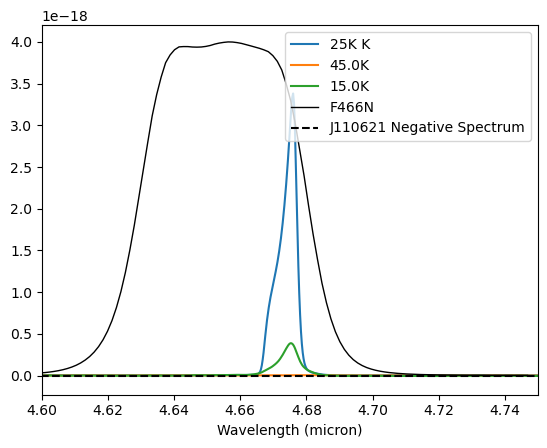

In [21]:
lis = co_map.list_consts_files('_CO_', verbose=False)[:3]
filterid = 'JWST/NIRCam.F466N'
xarr = np.linspace(filter_data.loc[filterid]['WavelengthMin'] * u.AA,
                   filter_data.loc[filterid]['WavelengthMax'] * u.AA,
                   1000)
xarr = np.linspace(3.5*u.um, 4.9*u.um, 5000)
phx4000 = atmo_model(4000, xarr=xarr)
i=0
for consts_file in lis:
    try: 
        consts = read_ocdb_file(f'{consts_file}')
        label = f'{consts.meta['temperature']}' + ' K'
    except:
        consts = Table.read(f'{consts_file}', format='ascii')
        consts.rename_column('col1', 'Wavenumber (cm⁻¹)_1')
        consts['Wavelength'] = 1e4 / consts['Wavenumber (cm⁻¹)_1'] * u.um
        consts.rename_column('col2', 'k')
        consts.meta['density'] = 1.0 * u.g / u.cm**3
        label = consts_file.split('/')[-1].split('_')[-1][:-4]
        consts.meta['composition'] = 'CO'
    molwt = composition_to_molweight(consts.meta['composition'])
    plt.plot(consts['Wavelength'], (consts['k'] * consts['Wavelength'].to(u.cm**-1, u.spectral()) * 4 * np.pi / (1*u.g/u.cm**3 / (28*u.Da))).to(u.cm**2), label=label)
    i+=1

trans = SvoFps.get_transmission_data(filterid)
plt.plot(trans['Wavelength'].quantity.to(u.um),
        trans['Transmission'].value/trans['Transmission'].value.max()*4e-18, label = 'F466N',
        linewidth=1,
        color='k')

plt.plot(tbl['Wavelength (micron)'], spec*80e-18, color='k', linestyle='--', label='J110621 Negative Spectrum')
plt.xlabel('Wavelength (micron)')
plt.xlim(4.6, 4.75)
plt.legend()

In [22]:
composition_to_molweight('CO:H2O (3:2)')

<Quantity 24.0122018 u>

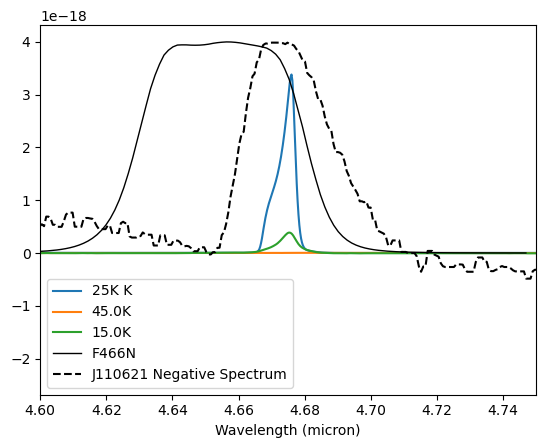

In [36]:
lis = co_map.list_consts_files('_CO_', verbose=False)[:3]
filterid = 'JWST/NIRCam.F466N'
xarr = np.linspace(filter_data.loc[filterid]['WavelengthMin'] * u.AA,
                   filter_data.loc[filterid]['WavelengthMax'] * u.AA,
                   1000)
xarr = np.linspace(3.5*u.um, 4.9*u.um, 5000)
phx4000 = atmo_model(4000, xarr=xarr)
i=0
for consts_file in lis:
    try: 
        consts = read_ocdb_file(f'{consts_file}')
        label = f'{consts.meta['temperature']}' + ' K'
    except:
        consts = Table.read(f'{consts_file}', format='ascii')
        consts.rename_column('col1', 'Wavenumber (cm⁻¹)_1')
        consts['Wavelength'] = 1e4 / consts['Wavenumber (cm⁻¹)_1'] * u.um
        consts.rename_column('col2', 'k')
        consts.meta['density'] = 1.0 * u.g / u.cm**3
        label = consts_file.split('/')[-1].split('_')[-1][:-4]
        consts.meta['composition'] = 'CO'
    molwt = composition_to_molweight(consts.meta['composition'])
    plt.plot(consts['Wavelength'], (consts['k'] * consts['Wavelength'].to(u.cm**-1, u.spectral()) * 4 * np.pi / (1*u.g/u.cm**3 / (molwt))).to(u.cm**2), label=label)
    i+=1

trans = SvoFps.get_transmission_data(filterid)
plt.plot(trans['Wavelength'].quantity.to(u.um),
        trans['Transmission'].value/trans['Transmission'].value.max()*4e-18, label = 'F466N',
        linewidth=1,
        color='k')

plt.plot(tbl['Wavelength (micron)'], spec_J11*80e-18, color='k', linestyle='--', label='J110621 Negative Spectrum')
plt.xlabel('Wavelength (micron)')
plt.xlim(4.6, 4.75)
plt.legend()

158_OCN-_1_1172_12.0K.txt
158_OCN-_1_1143_80.0K.txt


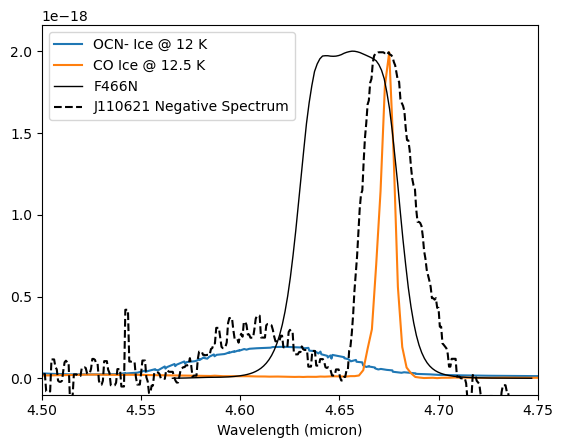

In [35]:
lis = co_map.list_consts_files('OCN', verbose=True)[:1]
for consts_file in lis:
    try: 
        consts = read_ocdb_file(f'{consts_file}')
    except:
        consts = Table.read(f'{consts_file}', format='ascii')
        consts.rename_column('col1', 'Wavenumber (cm⁻¹)_1')
        consts['Wavelength'] = 1e4 / consts['Wavenumber (cm⁻¹)_1'] * u.um
        consts.rename_column('col2', 'k')
        consts.meta['density'] = 1.0 * u.g / u.cm**3
        label = consts_file.split('/')[-1].split('_')[-1][:-4]
        consts.meta['composition'] = 'OCN'
    molwt = composition_to_molweight(consts.meta['composition'])
    plt.plot(consts['Wavelength'], (consts['k'] * consts['Wavelength'].to(u.cm**-1, u.spectral()) * 4 * np.pi / (1*u.g/u.cm**3 / (molwt))).to(u.cm**2), label='OCN- Ice @ 12 K')
    i+=1

lis = [f'{optical_constants_cache_dir}/1_CO_(1)_12.5K_Baratta.txt']
i=0
for consts_file in lis:
    try: 
        consts = read_ocdb_file(f'{consts_file}')
        label = f'{consts.meta['temperature']}' + ' K'
    except:
        consts = Table.read(f'{consts_file}', format='ascii')
        consts.rename_column('col1', 'Wavenumber (cm⁻¹)_1')
        consts['Wavelength'] = 1e4 / consts['Wavenumber (cm⁻¹)_1'] * u.um
        consts.rename_column('col2', 'k')
        consts.meta['density'] = 1.0 * u.g / u.cm**3
        label = consts_file.split('/')[-1].split('_')[-1][:-4]
        consts.meta['composition'] = 'CO'
    molwt = composition_to_molweight(consts.meta['composition'])
    plt.plot(consts['Wavelength'], (consts['k'] * consts['Wavelength'].to(u.cm**-1, u.spectral()) * 4 * np.pi / (1*u.g/u.cm**3 / (molwt))).to(u.cm**2), label='CO Ice @ 12.5 K')
    i+=1

trans = SvoFps.get_transmission_data(filterid)
plt.plot(trans['Wavelength'].quantity.to(u.um),
        trans['Transmission'].value/trans['Transmission'].value.max()*2e-18, label = 'F466N',
        linewidth=1,
        color='k')

plt.plot(tbl['Wavelength (micron)'], spec_J11*40e-18, color='k', linestyle='--', label='J110621 Negative Spectrum')
plt.xlabel('Wavelength (micron)')

plt.xlim(4.5, 4.75)
plt.ylim(bottom=-0.1e-18)
plt.legend()

# H2O + CO Ice

In [25]:
co_map.list_consts_files('_H2O:CO_', verbose=False)

['/red/adamginsburg/repos/icemodels/icemodels/data/141_H2O:CO_(1:100)_1111_30.0K.txt',
 '/red/adamginsburg/repos/icemodels/icemodels/data/141_H2O:CO_(1:100)_1110_10.0K.txt',
 '/red/adamginsburg/repos/icemodels/icemodels/data/39_H2O:CO_(20:1)_12K_Elsila.txt',
 '/red/adamginsburg/repos/icemodels/icemodels/data/142_H2O:CO_(100:14)_1112_10.0K.txt']

242_H2O_(1)_25K_Mastrapa.txt
240_H2O_(1)_25K_Mastrapa.txt
63_CO_(1)_25K_Gerakines.txt
64_CO_(1)_25K_Gerakines.txt


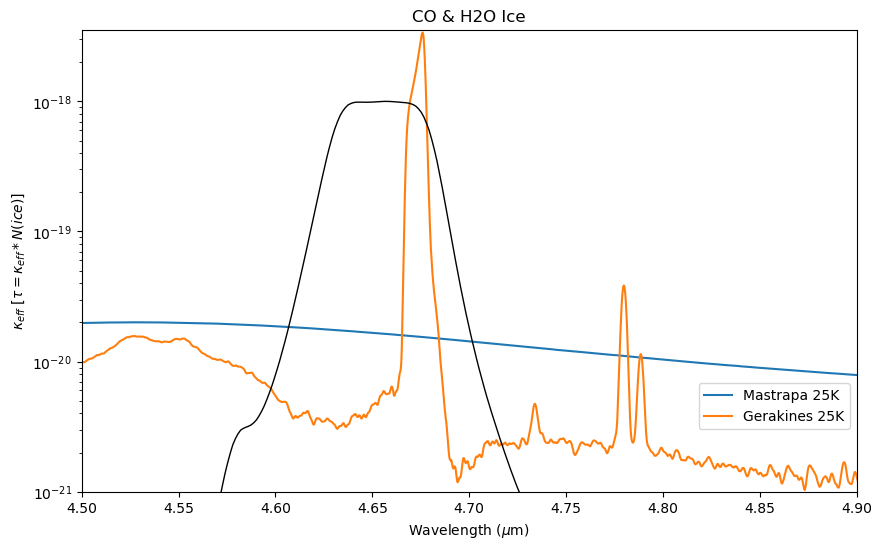

In [39]:
figure = plt.figure(figsize=(10, 6))
filterid = 'JWST/NIRCam.F466N'
xarr = np.linspace(filter_data.loc[filterid]['WavelengthMin'] * u.AA,
                   filter_data.loc[filterid]['WavelengthMax'] * u.AA,
                   1000)
xarr = np.linspace(3.5*u.um, 4.9*u.um, 5000)
phx4000 = atmo_model(4000, xarr=xarr)
lis = [co_map.list_consts_files('_H2O_*25*Mastrapa', verbose=True)[0], co_map.list_consts_files('_CO_*25*Gerakines', verbose=True)[0]]
#co_map.list_consts_files('_CO_', verbose=False)
i=0
for consts_file in lis:
    try: 
        consts = read_ocdb_file(f'{consts_file}')
        label = consts.meta['author'] + f' {consts.meta['temperature']}'
    except:
        print(':)')
        
    molwt = composition_to_molweight(consts.meta['composition'])#*u.Da
    plt.plot(consts['Wavelength'], (consts['k'] * consts['Wavelength'].to(u.cm**-1, u.spectral()) * 4 * np.pi / (1*u.g/u.cm**3 / (molwt))).to(u.cm**2), label=label)
    i+=1
plt.xlim(4.5, 4.9)
plt.ylim(bottom=1e-21)

trans = SvoFps.get_transmission_data(filterid)
plt.plot(trans['Wavelength'].quantity.to(u.um),
        trans['Transmission'].value/trans['Transmission'].value.max()*1e-18,
        linewidth=1,
        color='k')

plt.xlabel("Wavelength ($\\mu$m)")
plt.ylabel("$\\kappa_{eff}$ [$\\tau = \\kappa_{eff} * N(ice)$]")
plt.legend(loc='best', bbox_to_anchor=(1, 0.25))
plt.title('CO & H2O Ice')
plt.yscale('log')

In [38]:
composition_to_molweight(consts.meta['composition'])

<Quantity 18.015287 u>

In [48]:
consts_CO = read_ocdb_file(f'{optical_constants_cache_dir}/242_H2O_(1)_25K_Mastrapa.txt')
consts_H2O = read_ocdb_file(f'{optical_constants_cache_dir}/63_CO_(1)_25K_Gerakines.txt')
consts_lab = read_ocdb_file(f'{optical_constants_cache_dir}/39_H2O:CO_(20:1)_12K_Elsila.txt')
consts_lab2 = Table.read(f'{optical_constants_cache_dir}/142_H2O:CO_(100:14)_1112_10.0K.txt', format='ascii')
consts_lab2.rename_column('col1', 'Wavenumber (cm⁻¹)_1')
consts_lab2['Wavelength'] = 1e4 / consts_lab2['Wavenumber (cm⁻¹)_1'] * u.um
consts_lab2.rename_column('col2', 'k')
consts_lab2.meta['density'] = 1.0 * u.g / u.cm**3
consts_lab2.meta['composition'] = 'H2O:CO (100:14)'
consts_lab2.meta['temperature'] = 10
consts_lab3 = Table.read(f'{optical_constants_cache_dir}/141_H2O:CO_(1:100)_1110_10.0K.txt', format='ascii')
consts_lab3.rename_column('col1', 'Wavenumber (cm⁻¹)_1')
consts_lab3['Wavelength'] = 1e4 / consts_lab3['Wavenumber (cm⁻¹)_1'] * u.um
consts_lab3.rename_column('col2', 'k')
consts_lab3.meta['density'] = 1.0 * u.g / u.cm**3
consts_lab3.meta['composition'] = 'H2O:CO (1:100)'
consts_lab3.meta['temperature'] = 10

grid = consts_CO['Wavelength']
inds = np.argsort(consts_H2O['Wavelength'])
combo_k = consts_CO['k'] + np.interp(grid, consts_H2O['Wavelength'][inds], 20*consts_H2O['k'][inds],)
#combo_k = np.interp(consts_CO['Wavelength'], consts_H2O['Wavelength'], consts_H2O['k']*20) + consts_CO['k']
combo = Table([consts_CO['Wavelength'], combo_k], names=['Wavelength', 'k'])
combo.meta['density'] = 1.0 * u.g / u.cm**3
combo.meta['composition'] = 'CO:H2O (1:20)'
combo.meta['temperature'] = 25
combo.meta['author'] = 'Gerakines & Mastrapa'

(3e-22, 8.389823165772812e-17)

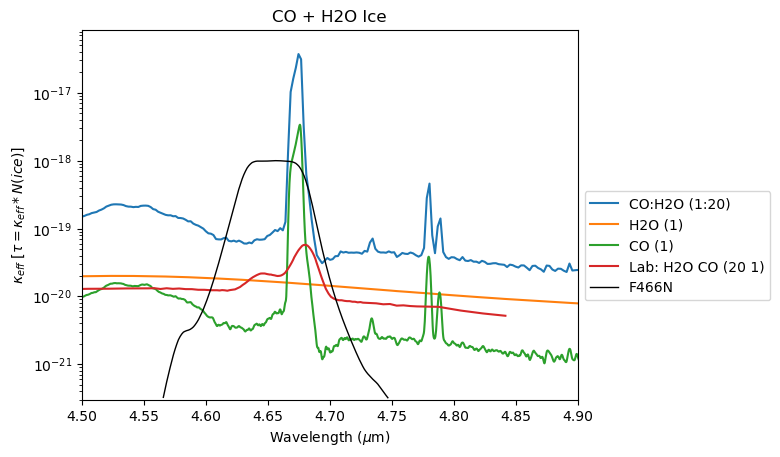

In [59]:
molwt = composition_to_molweight(combo.meta['composition'])#*u.Da
plt.plot(combo['Wavelength'], (combo['k'] * combo['Wavelength'].to(u.cm**-1, u.spectral()) * 4 * np.pi / (1*u.g/u.cm**3 / (molwt))).to(u.cm**2), label=combo.meta['composition'])
molwt = composition_to_molweight(consts_CO.meta['composition'])#*u.Da
plt.plot(consts_CO['Wavelength'], (consts_CO['k'] * consts_CO['Wavelength'].to(u.cm**-1, u.spectral()) * 4 * np.pi / (1*u.g/u.cm**3 / (molwt))).to(u.cm**2), label=consts_CO.meta['composition'])
molwt = composition_to_molweight(consts_H2O.meta['composition'])#*u.Da
plt.plot(consts_H2O['Wavelength'], (consts_H2O['k'] * consts_H2O['Wavelength'].to(u.cm**-1, u.spectral()) * 4 * np.pi / (1*u.g/u.cm**3 / (molwt))).to(u.cm**2), label=consts_H2O.meta['composition'])
molwt = composition_to_molweight(consts_lab.meta['composition'])#*u.Da
plt.plot(consts_lab['Wavelength'], (consts_lab['k'] * consts_lab['Wavelength'].to(u.cm**-1, u.spectral()) * 4 * np.pi / (1*u.g/u.cm**3 / (molwt))).to(u.cm**2), label=f'Lab: {consts_lab.meta['composition']}')

trans = SvoFps.get_transmission_data(filterid)
plt.plot(trans['Wavelength'].quantity.to(u.um),
        trans['Transmission'].value/trans['Transmission'].value.max()*1e-18,
        linewidth=1,
        color='k', label='F466N')

plt.xlabel("Wavelength ($\\mu$m)")
plt.ylabel("$\\kappa_{eff}$ [$\\tau = \\kappa_{eff} * N(ice)$]")
plt.legend(loc='best', bbox_to_anchor=(1, 0.25))
plt.title('CO + H2O Ice')
plt.yscale('log')
plt.xlim(4.5, 4.9)
plt.ylim(bottom=3e-22)